In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# 1. Load Dataset
file_path = "C:/Users/fikri/Library/Library python/ENV/data_sensor_baru3.csv"
dataset = pd.read_csv(file_path)

# Ambil data Orang 1
kolom_data_ax1 = dataset['AX']
kolom_data_ay1 = dataset['AY']
kolom_data_az1 = dataset['AZ']

# Hitung dan tampilkan nilai minimum dan maksimum
print("Orang 1:")
print("AX - Min:", kolom_data_ax1.min(), "| Max:", kolom_data_ax1.max())
print("AY - Min:", kolom_data_ay1.min(), "| Max:", kolom_data_ay1.max())
print("AZ - Min:", kolom_data_az1.min(), "| Max:", kolom_data_az1.max())


Orang 1:
AX - Min: -25.19 | Max: 38.09
AY - Min: -25.51 | Max: 41.26
AZ - Min: -20.24 | Max: 32.29


In [4]:
# 2. Extract Sensor Values and True Labels (diperbaiki)
Ax1_vals = dataset.iloc[:, 0].values  # AX
Ay1_vals = dataset.iloc[:, 1].values  # AY
Az1_vals = dataset.iloc[:, 2].values  # AZ

true_labels = dataset.iloc[:, 3].values  # Label

print(true_labels)


[0 0 0 ... 2 2 2]


In [5]:
# Analisis statistik dasar untuk AX, AY, AZ
print("Statistik AX:")
print(dataset['AX'].describe())

print("Statistik AY:")
print(dataset['AY'].describe())

print("Statistik AZ:")
print(dataset['AZ'].describe())


Statistik AX:
count    2635.000000
mean        0.154091
std         4.896978
min       -25.190000
25%        -0.995000
50%         0.180000
75%         1.245000
max        38.090000
Name: AX, dtype: float64
Statistik AY:
count    2635.000000
mean       -0.209074
std         7.916983
min       -25.510000
25%        -1.790000
50%        -0.010000
75%         1.485000
max        41.260000
Name: AY, dtype: float64
Statistik AZ:
count    2635.000000
mean        0.559651
std         6.373049
min       -20.240000
25%        -1.830000
50%        -0.180000
75%         1.670000
max        32.290000
Name: AZ, dtype: float64


In [6]:
range_dict = {}

for label in dataset['Label'].unique():
    data_label = dataset[dataset['Label'] == label]
    
    range_dict[label] = {
        'Ax1': (data_label['AX'].min(), data_label['AX'].max()),
        'Ay1': (data_label['AY'].min(), data_label['AY'].max()),
        'Az1': (data_label['AZ'].min(), data_label['AZ'].max())
    }

# Lihat hasilnya
for label, ranges in range_dict.items():
    print(f"Label {label}:")
    for axis, (min_val, max_val) in ranges.items():
        print(f"  {axis}: min = {min_val:.2f}, max = {max_val:.2f}")


Label 0:
  Ax1: min = -15.88, max = 16.48
  Ay1: min = -15.04, max = 10.09
  Az1: min = -20.24, max = 30.60
Label 1:
  Ax1: min = -25.19, max = 38.09
  Ay1: min = -25.51, max = 41.26
  Az1: min = -14.42, max = 32.29
Label 2:
  Ax1: min = -1.76, max = 2.13
  Ay1: min = -1.56, max = 3.11
  Az1: min = -2.62, max = 4.28


In [7]:
range_dict = {
    0: {  # Lompat
        'Ax1': (-15.88, 16.48),
        'Ay1': (-15.04, 10.09),
        'Az1': (-20.24, 30.60),
    },
    1: {  # Lari
        'Ax1': (-25.19, 38.09),
        'Ay1': (-25.51, 41.26),
        'Az1': (-14.42, 32.29),
    },
    2: {  # Naik Tangga
        'Ax1': (-1.76, 2.13),
        'Ay1': (-1.56, 3.11),
        'Az1': (-2.62, 4.28),
    }
}


In [20]:
def get_memberships(values, min_val, max_val):
    range_padding = 0.1 * (max_val - min_val)
    return fuzz.trimf(values, [
        min_val - range_padding,
        (min_val + max_val) / 2,
        max_val + range_padding
    ])


In [21]:
# 5. Fuzzification for Each Label
fuzzified = {}
for label in [0, 1, 2]:
    for axis in ['Ax1', 'Ay1', 'Az1']:
        min_val, max_val = range_dict[label][axis]
        fuzzified[f"{axis}_label{label}"] = get_memberships(eval(f"{axis}_vals"), min_val, max_val)

fuzzified_df = pd.DataFrame(fuzzified)

In [22]:
def apply_rule(label_num):
    part1 = np.fmin(np.fmin(
        fuzzified_df[f"Ax1_label{label_num}"],
        fuzzified_df[f"Ay1_label{label_num}"]
    ), fuzzified_df[f"Az1_label{label_num}"])
    
    return part1

# Apply rule untuk masing-masing label
rule1 = apply_rule(0)
rule2 = apply_rule(1)
rule3 = apply_rule(2)


In [23]:
# 7. Defuzzification and Output
sum_rules = rule1 + rule2 + rule3
sum_rules[sum_rules == 0] = 1e-6

# Gunakan bobot 0, 1, 2 karena itu label aslinya
crisp_output = (rule1 * 0 + rule2 * 1 + rule3 * 2) / sum_rules

# Tidak perlu tambah 1
predicted_label = np.round(crisp_output).astype(int)

# Pastikan hasil tetap dalam range 0–2
predicted_label = np.clip(predicted_label, 0, 2)

print(predicted_label)

0       1
1       1
2       1
3       1
4       1
       ..
2630    1
2631    1
2632    1
2633    1
2634    1
Length: 2635, dtype: int64


In [16]:
# 8. Save and Evaluate
hasil_akhir = dataset.copy()
hasil_akhir["prediksi_label"] = predicted_label
hasil_akhir.to_excel("hasil_prediksi_mamdani.xlsx", index=False)

print("Contoh hasil prediksi:")
print(hasil_akhir[["prediksi_label"]].head())

Contoh hasil prediksi:
   prediksi_label
0               1
1               1
2               1
3               1
4               1


In [17]:
# Evaluation
print("Akurasi:", accuracy_score(true_labels, predicted_label))
print(classification_report(true_labels, predicted_label))

Akurasi: 0.3240986717267552
              precision    recall  f1-score   support

           0       0.66      0.41      0.51      1002
           1       0.22      0.70      0.33       631
           2       0.00      0.00      0.00      1002

    accuracy                           0.32      2635
   macro avg       0.29      0.37      0.28      2635
weighted avg       0.30      0.32      0.27      2635



c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_label = dataset.iloc[:, -1].values # Ganti ini sesuai nama kolom label asli kamu
print(true_label)

[0 0 0 ... 2 2 2]


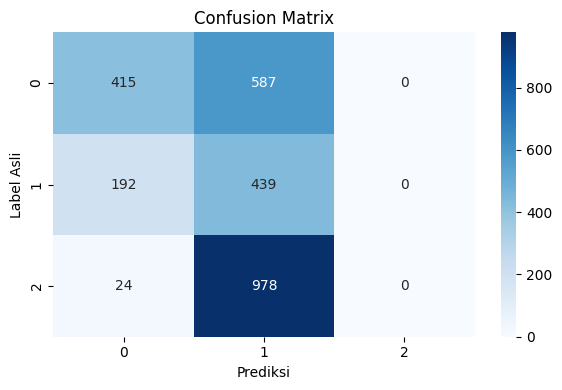

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.41      0.51      1002
           1       0.22      0.70      0.33       631
           2       0.00      0.00      0.00      1002

    accuracy                           0.32      2635
   macro avg       0.29      0.37      0.28      2635
weighted avg       0.30      0.32      0.27      2635



c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fikri\Library\Library python\ENV\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [19]:
# Confusion matrix
cm = confusion_matrix(true_label, predicted_label)

# Tampilkan dengan heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prediksi")
plt.ylabel("Label Asli")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Tampilkan laporan klasifikasi
print("Classification Report:")
print(classification_report(true_label, predicted_label))